# 1. Introduction

This is a lab for experimenting with trend-following ideas and techniques.  It includes the following features:

1. Data: downloads historical price data from various sources as input to the experiments.  It also simulates price data with various models to test different strategies.
1. `tr` class: a class for trading strategies upon a single asset.
1. `po` class: a class for portfolio evaluation: select assets, excecute trading strategies and evaluate performance.

In [1]:
# Put these at the top of every notebook, to get automatic reloading and inline plotting
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import os
import re
import pickle
import itertools
from datetime import datetime
from tqdm import tqdm
import numpy as np
import pandas as pd
from pandas import Series, DataFrame
pd.set_option('display.max_rows', 10)
import matplotlib as mpl
from matplotlib import pyplot as plt
import matplotlib.transforms as mtransforms
plt.rcParams['figure.figsize'] = [12, 4]

import ipyparallel as ipp

import quandl

In [3]:
# Utils
def dict_list_to_DataFrame(dl): 
    dl = [{k: [i] for k, i in d.items()} for d in dl]
    out = pd.concat([DataFrame.from_dict(d) for d in dl], sort=False)
    return out

def plot_prices(prices, name=''):
    fig, ax = plt.subplots()
    ax.plot(prices.Open)
    ax.plot(prices.High)
    ax.plot(prices.Low)
    ax.plot(prices.Close)
    ax.axhline(0, color='grey', lw=2, alpha=0.75)
    ax.set_title(name)
    ax.legend()



# 2. Data

The main sources of data are `Quandl`, `Cryptocompare` and `Yahoo Finance`.

## Quandl

In [4]:
api_key = open(file='quandl_api').read().replace('\n', '')
quandl.ApiConfig.api_key = api_key

In [5]:
QUANDL_PATH = 'input/Quandl/'
# ! ls {QUANDL_PATH}
print(os.listdir(QUANDL_PATH))

['SCF.csv', 'SCF.xlsx', 'XASE.csv', 'XASE.pickle', 'XBOM.csv', 'XBOM.pickle', 'XHKG.csv', 'XHKG.pickle', 'XJPX.csv', 'XLON.csv', 'XLON.pickle', 'XNAS.csv', 'XNAS.pickle', 'XNSE.csv', 'XNSE.pickle', 'XNYS.csv', 'XNYS.pickle', 'XSES.csv', 'XSES.pickle', 'XSHE.csv', 'XSHE.pickle', 'XSHG.csv', 'XSHG.pickle', 'XTSE.csv', 'XTSE.pickle', 'XTSX.csv', 'XTSX.pickle']


In [6]:
# Free sample tickers from Exchange Data International
QUANDL_FREE_SAMPLES_EDI = {
    # https://www.quandl.com/data/XNAS-NASDAQ-Stock-Market-Prices
    'XNAS': ['AAL', 'AAME', 'AAON', 'AAPL', 'AAXJ', 'ABAC', 'ABAX',
             'ABCO', 'ABG', 'ABM', 'ABTL', 'ACET', 'ACIW', 'ACLS', 'ACNB'],
    # https://www.quandl.com/data/XBOM-Bombay-Stock-Exchange-Prices
    'XBOM': ['500002', '500003', '500008', '500010', '500012',
             '500013', '500020', '500023', '500024', '500027',
             '500031', '500032', '500038', '500039', '500040'],
    # https://www.quandl.com/data/XTSE-Toronto-Stock-Exchange-Prices
    'XTSE': ['AAB', 'ABT', 'ABX', 'ACD', 'ACQ', 'AEM', 'AFN', 'AGT',
             'AGU', 'AIF', 'ALA', 'ALB', 'ALC', 'ALO', 'AND'],
    # https://www.quandl.com/data/XSHG-Shanghai-Stock-Exchange-Prices
    'XSHG' : ['600000', '600004', '600006', '600007', '600009',
              '600010', '600011', '600012', '600015', '600016',
              '600017', '600019', '600020', '600021', '600026'],
    # https://www.quandl.com/data/XLON-London-Stock-Exchange-Prices
    'XLON': ['AAIF', 'AAL', 'AAS', 'ABBY', 'ABC', 'ABF', 'ADIG', 
             'ADM', 'ADT', 'AEFS', 'AEO', 'AEP', 'AFN', 'AFS', 'AGK'],
    # https://www.quandl.com/data/XSES-Singapore-Exchange-Prices
    'XSES': ['1B6', '1C0', 'A04', 'A05', 'AFC', 'AGS', 'AUE', 'AVX', 
             'BBW', 'BCD', 'BCV', 'BCX',  'BCY', 'BEC', 'BESU'],
    # https://www.quandl.com/data/XNYS-New-York-Stock-Exchange-Prices
    'XNYS': ['A', 'AAT', 'AB', 'ABB', 'ABBV', 'ABC', 'ABEV', 'ABG', 
             'ABM', 'ABR', 'ABT', 'ABX', 'ACC', 'ADC', 'ADM'],
    # https://www.quandl.com/data/XHKG-Hong-Kong-Stock-Exchange-Prices
    'XHKG': ['00002', '00003', '00004', '00005', '00006',
             '00008', '00010', '00011', '00012', '00014',
             '00015', '00016', '00017', '00018', '00019'],
    # https://www.quandl.com/data/XASE-NYSE-MKT-AMEX-Prices
    'XASE': ['ABE', 'ACU', 'ACY', 'ADK', 'AE',  'AMS', 'ARNC_P',
             'BAA', 'BDL', 'BFY', 'BHB', 'BHV', 'BLE', 'BLJ', 'BTI'],
    # https://www.quandl.com/data/XNSE-National-Stock-Exchange-of-India-Prices
    'XNSE': ['ABB', 'ACC', 'ACE', 'ADSL', 'AFL', 'ALICON',
             'BAJAJ_AUTO', 'BASF', 'BASML', 'BBL', 'BEL',
             'BEPL, BHEL', 'BIL', 'BIOCON'],
    # https://www.quandl.com/data/XTSX-Toronto-Ventures-Stock-Exchange-Prices
    'XTSX': ['ABI', 'ABN', 'ADD', 'ADK', 'ADL', 'AFCC', 'AFM', 'AGD', 
             'AGO', 'AHR', 'AIIM', 'ALT', 'ALZ', 'AME', 'AMK'],
    # https://www.quandl.com/data/XSHE-Shenzhen-Stock-Exchange-Prices
    'XSHE': ['200011', '200012', '200018', '200025', '200026',
             '200055', '200056', '200413', '200418', '200488',
             '200521', '200530', '200539', '200541', '200550'],
    # https://www.quandl.com/data/XJPX-Japan-Exchange-Group-Prices/documentation/coverage
    'XJPX': ['13010', '13050', '13060', '13080', '13100', '13110', 
             '13200', '13290', '13300', '13320', '13430', '13440', 
             '13450', '13480', '13760']
}

In [7]:
# xjpx_df = DataFrame(data = np.arange(len(QUANDL_FREE_SAMPLES_EDI['XJPX'])),
#                     index=['XJPX/' + i for i in QUANDL_FREE_SAMPLES_EDI['XJPX']])
# xjpx_df.to_csv(path_or_buf='Input/Quandl/XJPX.csv', header=False)

In [8]:
def saf_quandl_get(dataset, **kwargs):
    try:
        return quandl.get(dataset, **kwargs)
    except:
        return None


def get_quandl_edi(exchanges = 'XNAS', free=True, download=False, flatten=True, verbose=False):
    """
    Downloads price series from Quandl vendor Exchange Data International
    
    Parameters
    ----------
    exchanges : List with names of the exchanges from which to download prices.
    free : If True, only free sample prices are downloaded.
    download : 
        If True, downloads the prices from quandl.  
        If False, looks for previously downloaded results in the QUANDL_PATH folder.
    verbose : If True, prints downloaded tickers.
    flatten: If True, returns a flattened dict with the results.
    
    Returns
    -------
    out : a dict or dict of dicts, of pandas DataFrame for each ticker.
    """
    
    out = dict()
    
    if download:
        for x in exchanges:
            
            prices = pd.read_csv(QUANDL_PATH + x + '.csv', names=['Ticker', 'Desc.'])
            free_sample = QUANDL_FREE_SAMPLES_EDI[x]
            which_free = [re.search('|'.join(free_sample), t) is not None and re.search('_UADJ', t) is None
                          for t in prices['Ticker']]
            if free: 
                prices = prices[which_free]
                
            if verbose:
                print('Downloading prices from', x, '...')
                
            out[x] = {t: saf_quandl_get(t) for t in prices['Ticker']}
            out[x] = {k: i for k, i in out[x].items() if i is not None}
            
            with open(QUANDL_PATH + x + '.pickle', 'wb') as f:
                pickle.dump(out[x], f, pickle.HIGHEST_PROTOCOL)
            
            if verbose:
                print(list(out[x].keys()))
    
    else:
        for x in exchanges:
            try:
                with open(QUANDL_PATH + x + '.pickle', 'rb') as f:
                    out[x] = pickle.load(f)
            except:
                pass
    
    if flatten:
        out = {k: i for x in out.keys() for k, i in out[x].items()}
    
    out = {k: i[['Open', 'High', 'Low', 'Close', 'Volume']] for k, i in out.items()}

    return out

# prices = get_quandl_edi(list(QUANDL_FREE_SAMPLES_EDI.keys()), download=True, verbose=True)

In [9]:
prices_dict = get_quandl_edi(list(QUANDL_FREE_SAMPLES_EDI.keys()))
print(list(prices_dict.keys()))

['XNAS/AAXJ', 'XNAS/AAON', 'XNAS/ABAX', 'XNAS/ABM', 'XNAS/ACET', 'XNAS/ACNB', 'XNAS/AAPL', 'XNAS/AAME', 'XNAS/ACLS', 'XNAS/AAL', 'XNAS/ABCO', 'XNAS/ABG', 'XNAS/ABAC', 'XNAS/ACIW', 'XBOM/500003', 'XBOM/500008', 'XBOM/500012', 'XBOM/500013', 'XBOM/500002', 'XBOM/500023', 'XBOM/500024', 'XBOM/500027', 'XBOM/500031', 'XBOM/500032', 'XBOM/500038', 'XBOM/500039', 'XBOM/500020', 'XBOM/500040', 'XBOM/500010', 'XTSE/AND', 'XTSE/AFN', 'XTSE/AGT', 'XTSE/ACQ', 'XTSE/ALA', 'XTSE/AIF', 'XTSE/ALB', 'XTSE/ALO', 'XTSE/ABT', 'XTSE/ACD', 'XTSE/AEM', 'XTSE/AGU', 'XTSE/ALC', 'XTSE/ABX', 'XTSE/AAB', 'XSHG/600020', 'XSHG/600015', 'XSHG/600021', 'XSHG/600019', 'XSHG/600009', 'XSHG/600016', 'XSHG/600007', 'XSHG/600000', 'XSHG/600006', 'XSHG/600017', 'XSHG/600011', 'XSHG/600010', 'XSHG/600026', 'XSHG/600012', 'XSHG/600004', 'XLON/ADM', 'XLON/ABC', 'XLON/AFS', 'XLON/AAIF', 'XLON/ADT', 'XLON/AEFS', 'XLON/AAS', 'XLON/AFN', 'XLON/AGK', 'XLON/AAL', 'XLON/AEP', 'XLON/ABF', 'XLON/ADIG', 'XLON/ABBY', 'XLON/AEO', 'XSES/

j: 124  -  XASE/ACY


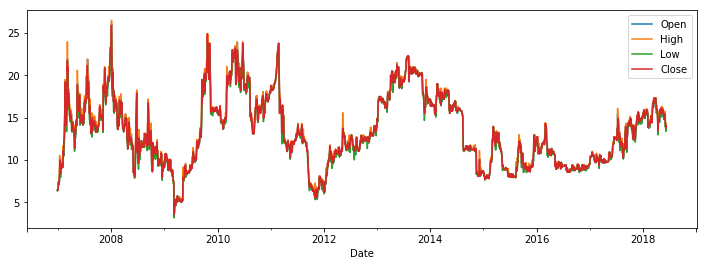

In [10]:
j = np.random.choice(len(prices_dict) - 1)
ticker_j = list(prices_dict.keys())[j]
print('j:', j, ' - ', ticker_j)
prices_dict[ticker_j][['Open', 'High', 'Low', 'Close']].plot()

In [11]:
prices_dict[ticker_j].head()

,Open,High,Low,Close,Volume
Date,,,,,
2006-12-28,6.39,6.45,6.35,6.45,2000.0
2006-12-29,6.45,6.46,6.45,6.46,1900.0
2007-01-01,6.46,6.46,6.46,6.46,0.0
2007-01-02,6.46,6.46,6.46,6.46,0.0
2007-01-03,6.58,7.15,6.58,7.00,13500.0


## Cryptocompare

## Yahoo Finance

## Data pre-processing

* OHLC: open and close within [low, high].

# 3. Trading Strategies

## 3.1 Definitions

In [ ]:
class Trade:
    """
    Class that performs a trading strategy on a single asset.
    """
    
    def __init__(self, prices, name='', strategy=None, skid=0.5):
        """
        Initializes trade class.
        
        Parameters
        ----------
        prices : a prices data frame with a Date index and columns: Open, High, Low, Close, Volume.
        strategy : An instance of class trading_strategy.
        name : name of the asset to trade.
        skid : skid for excecution of orders in the strategy (see http://www.seykota.com/tribe/TSP/SR/index.htm)
        """
        self.name = name
        self.prices = prices.sort_index()
        self.limit_orders = None
        self.trades = None
        self.value = None
        self.skid = skid
        self.strategy = strategy
    
    
    def plot_prices(self):
        self.prices[['Open', 'High', 'Low', 'Close']].plot()
        plt.title(self.name)


class Trading_Strategy:
    """
    Class that performs a trading strategy on a single asset.
    """
    
    def __init__(self, prices, equity=100, heat=0.05, position_step=100, name=''):
        """
        Defines the initial state and hyper parameters of the trading strategy.
        
        Parameters
        ----------
        prices: DataFrame with columns Date, Open, High, Low, Close
        equity: Initial equity to invest in the asset.
        heat: Proportion of the equity that one is willing to risk.
        position_step: Minimum steps in position' sizes
        name: Name of the asset for plotting purposes.
        """
        self.prices = prices
        self.heat = heat
        self.position_step = position_step
        self.name = name
        self.today = None
        self.today_prices = None
        self.equity = [{'Date': None,
                        'Available_Balance': equity, 'Closing_Balance': equity,
                        'Position': 0, 'Open_Profit': 0, 
                        'Position_Value': 0, 'Equity': equity}]
        self.max_drawdown = 0
        self.state = []
        self.orders = []
        self.trades = []
        self.performance = {}
    
        
    
    def orders_before_trading_starts(self, prices, prev_day_position, prev_day_state, **kwargs):
        """
        Computes the orders for the day (today).
        
        Parameters
        ----------
        prices : a prices data frame with a Date index and columns: Open, High, Low, Close, Volume.
            Prices until today only for accessing current date.
        prev_day_position : position in the asset at the end of yesterday.
        """
        pass
    
    def excecute_orders(self, equity_to_risk=100, skid=0.5):
        """
        Excecutes orders during the day.
        """
        
        if self.equity[-1]['Date'] is None:  # First day: do nothing.
            self.equity[-1]['Date'] = self.prices.index[0]
        else:
            position = self.equity[-1]['Position']  # previous day's position
            balance = self.equity[-1]['Available_Balance']
            o = self.orders[-1]
            tp = self.today_prices
            
            if position == 0:  # Enter the market.
                
                if o['buy_stop'] is not None and o['protective_sell'] is not None and o['buy_stop'] > o['protective_sell'] and tp.High > o['buy_stop']:
                    buy_price = tp.High - skid * (tp.High - max(tp.Open, tp.Low, o['buy_stop']))
                    trade = {'Date': self.today,
                             'Price': buy_price,
                             'Amount': min(o['amount'], balance)}
                    position += o['amount']
                    balance -= o['amount'] * buy_price
                    self.trades.append(trade)
                    
                    
                elif o['sell_stop'] is not None and o['protective_buy'] is not None and o['sell_stop'] < o['protective_buy'] and tp.Low < o['sell_stop']:
                    sell_price = tp.Low + skid * (min(tp.Open, tp.High, o['sell_stop']) - tp.Low)
                    trade = {'Date': self.today,
                             'Price': sell_price,
                             'Amount': max(o['amount'], -balance)}  # o['amount'] < 0
                    position += o['amount']
                    balance -= o['amount'] * sell_price
                    self.trades.append(trade)
                    
            if position != 0:  # Close positions.
                
                if o['protective_buy'] is not None and tp.High > o['protective_buy']:
                    buy_price = tp.High - skid * (tp.High - max(tp.Open, tp.Low, o['protective_buy']))
                    amount = max(-position, 0)
                    trade = {'Date': self.today,
                             'Price': buy_price,
                             'Amount': amount}
                    position += amount
                    balance -= amount * buy_price
                    self.trades.append(trade)
                    
                if o['protective_sell'] is not None and tp.Low < o['protective_sell']:
                    sell_price = tp.Low + skid * (min(tp.Open, tp.High, o['protective_sell']) - tp.Low)
                    amount = min(-position, 0)
                    trade = {'Date': self.today,
                             'Price': sell_price,
                             'Amount': amount}
                    position += amount
                    balance -= amount * sell_price
                    self.trades.append(trade)
            
            if self.today == self.prices.index.values[-1] and position != 0:  # Last day
                if position > 0:
                    sell_price = tp.Low + skid * (min(tp.Open, tp.Close, tp.High) - tp.Low)
                    amount = min(-position, 0)
                    trade = {'Date': self.today,
                             'Price': sell_price,
                             'Amount': amount}
                    position += amount
                    balance -= amount * sell_price
                    self.trades.append(trade)
                else:  # position < 0
                    buy_price = tp.High - skid * (tp.High - max(tp.Open, tp.Close, tp.Low))
                    amount = max(-position, 0)
                    trade = {'Date': self.today,
                             'Price': buy_price,
                             'Amount': amount}
                    position += amount
                    balance -= amount * buy_price
                    self.trades.append(trade)
            
            if position != 0:
                open_profit = position * (tp.Close - self.trades[-1]['Price'])
            else:
                open_profit = 0
            
            if self.equity[-1]['Position'] != 0 and position == 0:
                closing_balance = balance
            else:
                closing_balance = self.equity[-1]['Closing_Balance']
            
            
            self.equity.append({'Date': self.today, 'Available_Balance': balance, 'Closing_Balance': closing_balance,
                                'Position': position, 'Open_Profit': open_profit,
                                'Position_Value': position * tp.Close,
                                'Equity': balance + position * tp.Close})
    
    
    def excecute(self, warmup=25, end=None):
        """
        Excecutes the trading strategy and computes its performance measures.
        
        Parameters
        ----------
        warmup: warmup period in days or a proportion from 0 to 1.
        end: either a datetime or a proportion from 0 to 1 (all sample).
        """
        peak = self.equity[0]['Equity']
        low = peak
        drawdown = 0
        max_drawdown = 0
        
        if end is None:
            end = self.prices.index[-1]
        elif type(end) == float:
            end = self.prices.index[int(len(self.prices) * end)]
        
        if warmup < 1:
            warmup = int(len(self.prices) * warmup)
            
        for i in range(1, len(self.prices)):
            self.update_state(i)
            if i >= warmup - 1:
                self.orders_before_trading_starts()
                self.excecute_orders()
                
                # Max drawdown
                if self.equity[-1]['Equity'] > peak:
                    peak = self.equity[-1]['Equity']
                    low = peak
                if self.equity[-1]['Equity'] < low:
                    low = self.equity[-1]['Equity']
                    drawdown = low / peak - 1
                max_drawdown = min(drawdown, max_drawdown)
            if self.today > end:
                break
        
        self.max_drawdown = max_drawdown
        self.compute_performance()
        

    def compute_performance(self):
        """
        Computes performance indicators for the trading strategy.
        """
        # The date in the first entry of equity is None
        self.performance['Years'] = (self.equity[-1]['Date'] - self.equity[1]['Date'] ).days / 364.25
        self.performance['Ratio'] = self.equity[-1]['Equity'] / self.equity[0]['Equity']
        # Instantaneously Compounding Annual Gain
        self.performance['ICAGR'] = np.log(self.performance['Ratio']) / self.performance['Years']
        self.performance['Max_Drawdown'] = -self.max_drawdown
        # How Often the System Earns Back its Biggest Drawdown
        self.performance['Bliss'] = self.performance['ICAGR'] / self.performance['Max_Drawdown']
        
        eqty = np.array([d['Equity'] for d in self.equity][1:])
        self.performance['Volatility'] = np.std(np.log(eqty[1:] / eqty[:-1])) * np.sqrt(364.25)
        
        # Lake Ratio (see http://www.seykota.com/tribe/risk/index.htm)
        lake_bottom = Series(eqty) / self.equity[1]['Equity']
        lake_surface = lake_bottom.cummax()

        earth = np.trapz(lake_bottom.values)
        water = np.trapz(lake_surface - lake_bottom)
        self.performance['Lake_Ratio'] = water / earth
        
        earth0 = np.trapz(lake_bottom.values - 1)
        self.performance['Sea_Ratio'] = water / earth0
        
        
    
    def get_state(self):
        if not any([i == 'state_df' for i in dir(self)]):
            self.state_df = dict_list_to_DataFrame(self.state).set_index('Date')
        return self.state_df
    
    
    def get_orders(self):
        if not any([i == 'orders_df' for i in dir(self)]):
            self.orders_df = dict_list_to_DataFrame(self.orders).set_index('Date')
        return self.orders_df
    
    
    def get_trades(self):
        if not any([i == 'trades_df' for i in dir(self)]):
            self.trades_df = dict_list_to_DataFrame(self.trades).set_index('Date')
        return self.trades_df
    
    
    def get_equity(self):
        if not any([i == 'equity_df' for i in dir(self)]):
            self.equity_df = pd.merge(self.prices[['Open']],
                                      dict_list_to_DataFrame(self.equity).set_index('Date'),
                                      left_index=True, right_index=True,
                                      how='left')
            self.equity_df = self.equity_df.drop('Open', axis=1)
            self.equity_df = self.equity_df.fillna(method='ffill')
        return self.equity_df
    
    
    
    
    def plot_prices(self):
        fig, ax = plt.subplots()
        ax.plot(self.prices.Open)
        ax.plot(self.prices.High)
        ax.plot(self.prices.Low)
        ax.plot(self.prices.Close)
        ax.axhline(0, color='grey', lw=2, alpha=0.75)
        ax.set_title(self.name)
        ax.legend()
    
    def plot_state(self):
        pass
    
    def plot_equity(self):
        x = pd.merge(self.get_equity(), self.get_state(), left_index=True, right_index=True, how = 'outer')
        tit = self.name + ' - days_fast: ' + str(self.days_fast) + ', days_slow: ' + str(self.days_slow) + ', '
        tit += 'heat: ' + str(self.heat) + '.\n'
        tit += 'Initial Equity: ' + str(int(self.equity[0]['Equity']))
        tit += ', Ending Equity: ' + str(int(self.equity[-1]['Equity'])) + ', '
        tit += 'Total Return: ' + str(int(10000 * self.equity[-1]['Equity'] / self.equity[1]['Equity'] - 1) / 100) + '%, '
        tit += 'ICAGR: ' + str(int(10000 * self.performance['ICAGR']) / 100) + '%.\n'
        tit += 'Volatility: ' + str(int(10000 * self.performance['Volatility']) / 100) + '%, '
        tit += 'Lake Ratio: ' + str(int(10000 * self.performance['Lake_Ratio']) / 100) + '%, '
        tit += 'Max. Drawdown: ' + str(int(10000* self.performance['Max_Drawdown']) / 100) + '%, '
        tit += 'Bliss: ' + str(np.round(364.25 * self.performance['Bliss'], 1)) + ' days.'
        pal = plt.get_cmap('Paired').colors
        fig, ax = plt.subplots()
        trans = mtransforms.blended_transform_factory(ax.transData, ax.transAxes)
        ax.fill_between(x.index, 0, x.Equity.max(), where= x.Trend > 0, facecolor=pal[0], alpha=0.25, transform=trans, label='Trend up')
        ax.fill_between(x.index, 0, x.Equity.max(), where= x.Trend < 0, facecolor=pal[4], alpha=0.25, transform=trans, label='Trend down')
        ax.plot(x.index, x.Equity)
        ax.plot(x.index, x.Closing_Balance)
        ax.axhline(0, color='grey', lw=2, alpha=0.75)
        ax.set_title(tit)
        ax.legend()
    
    
    def plot_lake_ratio(self):
        """
        Illustrates the computation of the lake ratio.
        See http://www.seykota.com/tribe/risk/index.htm
        """
        lake_bottom = Series([d['Equity'] for d in self.equity[1:]],
                             index=[d['Date'] for d in self.equity[1:]]) / self.equity[1]['Equity']
        lake_surface = lake_bottom.cummax()
        fig, ax = plt.subplots()
        ax.fill_between(lake_bottom.index, y1 = lake_bottom, y2 = lake_surface, alpha=0.5)
        ax.fill_between(lake_bottom.index, y1 = 0, y2 = lake_bottom, alpha=0.5)
        ax.axhline(1, color='grey', lw=2, alpha=0.75)
        ax.axhline(0, color='grey', lw=2, alpha=0.75)
        ax.plot(lake_bottom)
        tit = 'Lake Ratio: ' + str(int(10000 * self.performance['Lake_Ratio']) / 100) + '%'
        tit += ', Sea Ratio (areas over 1): ' + str(int(10000 * self.performance['Sea_Ratio']) / 100) + '%.'
        ax.set_title(tit)




class RS_Trading_Strategy(Trading_Strategy):
    """
    Implements a Support and Resistance trading system, 
    based on http://www.seykota.com/tribe/TSP/SR/index.htm.
    """
    
    def __init__(self, prices, equity=100000, heat=0.05, position_step=1, days_fast=20, days_slow=140, name=''):
        """
        Parameters
        ----------
        days_fast: days in the moving window for computing the fast support and resistance.
        days_slow: days in the moving window for computing the slow support and resistance.
        """
        self.prices = prices
        self.heat = heat
        self.position_step = position_step
        self.name = name
        self.today = None
        self.today_prices = None
        self.equity = [{'Date': None,
                        'Available_Balance': equity, 'Closing_Balance': equity,
                        'Position': 0, 'Open_Profit': 0, 
                        'Position_Value': 0, 'Equity': equity}]
        self.peak = equity
        self.low = equity
        self.max_drawdown = 0
        self.state = []
        self.orders = []
        self.trades = []
        self.performance = {}
        self.days_fast = days_fast
        self.days_slow = days_slow
        
    
    
    def update_state(self, today_i):
        """
        Updates the Resistance, Support, and Trend variables.
        """
        self.today = self.prices.index[today_i]
        self.today_prices = self.prices.iloc[today_i]
        prices = self.prices.iloc[:today_i]  # All but today
        
        # State calculations
        Support_slow = prices[-self.days_slow:].Low.min()
        Support_fast = prices[-self.days_fast:].Low.min()
        Resistance_slow = prices[-self.days_slow:].High.max()
        Resistance_fast = prices[-self.days_fast:].High.max()
        last_price = prices.iloc[today_i - 1]
        if last_price.High >= Resistance_slow and last_price.Low > Support_slow:
            Trend = 1
        elif last_price.Low <= Support_slow and last_price.High < Resistance_slow:
            Trend = -1
        elif len(self.state) > 0:
            Trend = self.state[-1]['Trend']
        else:
            Trend = 0
        
        self.state.append(dict(Support_slow=Support_slow,
                               Support_fast=Support_fast,
                               Resistance_slow=Resistance_slow,
                               Resistance_fast=Resistance_fast,
                               Trend=Trend,
                               Date=prices.index[-1]))
    
    
    def orders_before_trading_starts(self):
        """
        Computes the orders for the day (today) according to a Support and Resistance system.
        """
        
        # Orders
        prev_day_position = self.equity[-1]['Position']
        equity_to_risk = self.equity[-1]['Available_Balance'] * self.heat
        state = self.state[-1]
        Trend = state['Trend']
        
        orders = dict(Date = self.today,
                      buy_stop = None, sell_stop=None,
                      protective_buy=None, protective_sell=None)
        
        if prev_day_position == 0:
            if Trend == 1:
                orders['buy_stop'] = state['Resistance_fast']
                orders['protective_sell'] = state['Support_fast']
                orders['risk_per_lot'] = orders['buy_stop'] - orders['protective_sell'] + 1e-12
                orders['amount'] = self.position_step * np.round((1e-8 + equity_to_risk / orders['risk_per_lot']) / self.position_step)
            elif Trend == -1:
                orders['sell_stop'] = state['Support_fast']
                orders['protective_buy'] = state['Resistance_fast']
                orders['risk_per_lot'] = orders['protective_buy'] - orders['sell_stop'] + 1e-12
                orders['amount'] = - self.position_step * np.round((1e-8 + equity_to_risk / orders['risk_per_lot']) / self.position_step)
        elif prev_day_position > 0:
            orders['protective_sell'] = state['Support_fast']
        elif  prev_day_position < 0:
            orders['protective_buy'] = state['Resistance_fast']
        else:
            pass
        
        self.orders.append(orders)
        
        
    def plot_state(self):
        x = pd.merge(self.prices, self.get_state(), left_index=True, right_index=True, how='outer')
        tit = self.name + ' - days_fast: ' + str(self.days_fast) + ', days_slow: ' + str(self.days_slow) + '.'
        pal = plt.get_cmap('Paired').colors
        fig, ax = plt.subplots()
        trans = mtransforms.blended_transform_factory(ax.transData, ax.transAxes)
        ax.fill_between(x.index, 0, x.High.max(), where= x.Trend > 0, facecolor=pal[0],
                        alpha=0.25, transform=trans, label='Trend up')
        ax.fill_between(x.index, 0, x.High.max(), where= x.Trend < 0, facecolor=pal[4],
                        alpha=0.25, transform=trans, label='Trend down')

        ax.plot(x.index, x.High, c=pal[1])
        ax.plot(x.index, x.Low, c=pal[0])
        ax.plot(x.index, x.Resistance_fast, c=pal[2])
        ax.plot(x.index, x.Resistance_slow, c=pal[3])
        ax.plot(x.index, x.Support_fast, c=pal[4])
        ax.plot(x.index, x.Support_slow, c=pal[5])
        ax.axhline(0, color='grey', lw=2, alpha=0.75)
        ax.legend()
        ax.set_title(tit)

    
def test_RS_Trading_Strategy():
    """
    Make sure the results match those on http://www.seykota.com/tribe/TSP/SR/index.htm..
    """

    price = pd.read_csv(filepath_or_buffer='test/Seykota GC----C.csv', header=None,
               names=['Date', 'Open', 'High', 'Low', 'Close', 'Volume', 'Open_Interest'], 
               index_col=0)

    price.index = [datetime.strptime(str(i), '%Y%m%d') for i in price.index.values]

    rs_tr = RS_Trading_Strategy(price, equity=1e6, position_step=1e2,
                                days_fast=20, days_slow=140,
                                name='Comex Gold')
    rs_tr.excecute(warmup=20)

    # test states
    stts = rs_tr.get_state()
    metrics = pd.merge(price[['Open', 'High', 'Low', 'Close']], stts, left_index=True, right_index=True)
    metrics_log = pd.read_excel(io='test/Metrics_Log_1-1.xlsx', index_col=0)
    assert np.all(np.equal(metrics_log.values, metrics.values))

    # test trades
    trds = rs_tr.get_trades()
    trade_log = pd.read_excel(io='test/Trade_Log.xlsx').set_index('Date').sort_index()[['Price', 'Amount']]
    assert max(abs(trds.Price.values - trade_log.Price.values)) < 1e-3
    assert trds.Amount.equals(trade_log.Amount.astype('float64'))

    # test equity
    eqty = rs_tr.get_equity()
    equity_log = pd.read_excel(io='test/Equity_Log.xlsx', index_col=0)
    assert max(abs(eqty.Equity.values - equity_log.Equity.values)) < 1e-3
    assert np.max(np.abs(equity_log.Clo_Bal - rs_tr.get_equity().Closing_Balance)) < 1e-3
    assert np.max(np.abs(equity_log.Open_Profit - rs_tr.get_equity().Open_Profit)) < 1e-3

    # test performance indicators
    assert np.round(rs_tr.performance['ICAGR'], 4) == 0.0309
    assert np.round(rs_tr.performance['Max_Drawdown'], 4) == 0.4077
    assert np.round(rs_tr.performance['Bliss'], 4) == 0.0758



In [ ]:
test_RS_Trading_Strategy()

## 3.2 Trading Tribe example

Here, we reproduce Ed Sykota's trading tribe [example](http://www.seykota.com/tribe/tsp/SR/SYS_SR_140-20_05_v_15/index.htm) on a Support and Resistance trading system.

In [ ]:
price = pd.read_csv(filepath_or_buffer='test/Seykota GC----C.csv', header=None,
                   names=['Date', 'Open', 'High', 'Low', 'Close', 'Volume', 'Open_Interest'], 
                   index_col=0)
price.index = [datetime.strptime(str(i), '%Y%m%d') for i in price.index.values]

rs_tr = RS_Trading_Strategy(price, equity=1e6, position_step=1e2,
                            days_fast=20, days_slow=140, name='Comex Gold')
rs_tr.excecute(warmup=20)

In [ ]:
rs_tr.performance
# rs_tr.get_state()
# rs_tr.get_trades()
# rs_tr.get_equity()

In [ ]:
rs_tr.plot_prices()
rs_tr.plot_state()
rs_tr.plot_equity()
rs_tr.plot_lake_ratio()

## 3.3 With a random asset

* TO DO: curate series. Eg.:
    * XNAS/AAPL
    * XTSX/AMK
    * XTSE/ACD
    * XTSX/ADK
    * XTSX/ALZ
    * XTSX/ADK
    * XSES/A04
    * XTSX/AHR

In [ ]:
j = np.random.choice(len(prices_dict) - 1)
ticker_j = list(prices_dict)[j]; print(ticker_j, '-', len(prices_dict[ticker_j]), 'days.')
pr_j = prices_dict[ticker_j]

In [ ]:
plot_prices(pr_j, ticker_j)

In [ ]:
rs_j = RS_Trading_Strategy(pr_j, equity=1e6, days_fast=40, days_slow=120, name=str(j) + ' - ' + ticker_j)
rs_j.excecute(warmup=0.05)

In [ ]:
rs_j.performance

In [ ]:
rs_j.plot_state()
rs_j.plot_equity()
rs_j.plot_lake_ratio()

### 3.3.1 Optimizing hyper parameters

#### Grid Search

In [ ]:
def grid_search(price_df, name="",
                min_days=20, max_days=400, step=20, min_dif=50,
                warmup=None, tr_size=0.5, heat=0.05, equity=1e6,
                return_df=True):
        
    slow = np.arange(20, 420, 20)
    fast = np.arange(20, 420, 20)

    res_train = []
    res_val = []
    for s, f in itertools.product(slow, fast):
        if f > (s - 50): 
            continue
        else:
            # Training
            if warmup is None:
                warmup = s
            
            rs_train = RS_Trading_Strategy(price_df, equity=equity, heat=heat,
                                           days_fast=f, 
                                           days_slow=s,
                                           name=name)
            rs_train.excecute(warmup=warmup, end = tr_size)
            res_train.append({'Slow': s, 'Fast': f, 'Type': 'train', **rs_train.performance})

            # Validation
            rs_val = RS_Trading_Strategy(price_df, equity=equity, heat=heat,
                                         days_fast=f, 
                                         days_slow=s,
                                         name=name)
            rs_val.excecute(warmup=tr_size)
            res_val.append({'Slow': s, 'Fast': f, 'Type': 'train', **rs_val.performance})
    
    if return_df:
        res_train = dict_list_to_DataFrame(res_train)
        res_val = dict_list_to_DataFrame(res_val)
    
    return res_train, res_val

In [ ]:
res_train, res_val = grid_search(pr_j, ticker_j, step=100)

In [ ]:
res_val.ICAGR.hist(bins = 50)

In [ ]:
y_lab = ['ICAGR']
x_lab = ['Max_Drawdown', 'Lake_Ratio', 'Sea_Ratio', 'Volatility']
c_lab = 'Bliss'

print(ticker_j, '- Color: ' + c_lab + ' (days)')
fig, axes = plt.subplots(nrows=2 * len(y_lab), ncols=len(x_lab), squeeze=False, figsize=(14, 4))

axes[0, 0].set_title('Training')
for i, j in itertools.product(np.arange(len(y_lab)), np.arange(len(x_lab))):
    im = axes[i, j].scatter(res_train[x_lab[j]], res_train[y_lab[i]], c=res_train[c_lab] * 364.25)
    axes[i, j].axhline(0, color='grey', alpha=0.75)
    if i == len(y_lab) - 1:
        axes[i, j].set_xlabel(x_lab[j])
    if j == 0:
        axes[i, j].set_ylabel(y_lab[i])
    if j == len(x_lab) - 1:
        fig.colorbar(im, ax=axes[i, j])

axes[1, 0].set_title('Validation')
for i, j in itertools.product(np.arange(len(y_lab)), np.arange(len(x_lab))):
    im = axes[1 + i, j].scatter(res_val[x_lab[j]], res_val[y_lab[i]], c=res_val[c_lab] * 364.25)
    axes[1 + i, j].axhline(0, color='grey', alpha=0.75)
    if i == len(y_lab) - 1:
        axes[1 + i, j].set_xlabel(x_lab[j])
    if j == 0:
        axes[1 + i, j].set_ylabel(y_lab[i])
    if j == len(x_lab) - 1:
        fig.colorbar(im, ax=axes[1+i, j])

In [ ]:
plt.scatter(res_val.Slow, res_val.Fast, s= 10 + 100 * (res_val.ICAGR > 0),
            c= 364.25 * res_val.Bliss)
plt.colorbar()
plt.legend()

### 3.3.2 Best configuration

In [ ]:
res_train[['Slow', 'Fast']].iloc[res_train.ICAGR.idxmax()]

In [ ]:
s, f = res_train[['Slow', 'Fast']].iloc[res_train.ICAGR.idxmax()]; print(ticker_j, s, f, sep=', ')
tr_j = RS_Trading_Strategy(pr_j, equity=1e6, 
                           days_fast=int(f), days_slow=int(s),
                           name=str(j) + ' - ' + ticker_j)
tr_j.excecute(warmup=0.5)

In [ ]:
tr_j.performance
# tr_j.get_equity()

In [ ]:
tr_j.plot_state()
tr_j.plot_equity()
tr_j.plot_lake_ratio()

# 4. Multiple Assets

In [12]:
def grid_search(price_df, name="",
                min_days=20, max_days=400, step=20, min_dif=50,
                warmup=None, tr_size=0.5, heat=0.05, equity=1e6,
                return_df=True):
        
    slow = numpy.arange(20, 420, 20)
    fast = numpy.arange(20, 420, 20)

    res_train = []
    res_val = []
    for s, f in itertools.product(slow, fast):
        if f > (s - 50): 
            continue
        else:
            # Training
            if warmup is None:
                warmup = s
            
            rs_train = RS_Trading_Strategy(price_df, equity=equity, heat=heat,
                                           days_fast=f, 
                                           days_slow=s,
                                           name=name)
            rs_train.excecute(warmup=warmup, end = tr_size)
            res_train.append({'Slow': s, 'Fast': f, 'Type': 'train', **rs_train.performance})

            # Validation
            rs_val = RS_Trading_Strategy(price_df, equity=equity, heat=heat,
                                         days_fast=f, 
                                         days_slow=s,
                                         name=name)
            rs_val.excecute(warmup=tr_size)
            res_val.append({'Slow': s, 'Fast': f, 'Type': 'train', **rs_val.performance})
    
    if return_df:
        res_train = dict_list_to_DataFrame(res_train)
        res_val = dict_list_to_DataFrame(res_val)
    
    return res_train, res_val

In [33]:
import ipyparallel as ipp
rc = ipp.Client()
rc[:].use_dill()
rc.ids

[0, 1, 2, 3, 4, 5]

In [34]:
view = rc.direct_view() # rc.load_balanced_view() # 

with view.sync_imports():
    import trading_strategy_parallel

view.push(dict(np = np))

importing trading_strategy_parallel on engine(s)


<AsyncResult: _push>

In [35]:
async_results = []

In [36]:
tickers = list(prices_dict)[:5]; print(tickers)
prices = [prices_dict[t] for t in tickers]

for p, t in zip(prices, tickers):
    # This line submits the tasks for parallel computation.
    ar = view.apply_async(grid_search, p, t)
    async_results.append(ar)

rc.wait(async_results)  # Wait until all tasks are done.

['XNAS/AAXJ', 'XNAS/AAON', 'XNAS/ABAX', 'XNAS/ABM', 'XNAS/ACET']


True

In [37]:
len(async_results)

5

In [38]:
results = [ar.get() for ar in async_results]

CompositeError: one or more exceptions from call to method: grid_search
[0:apply]: NameError: name 'np' is not defined
[1:apply]: NameError: name 'np' is not defined
[2:apply]: NameError: name 'np' is not defined
[3:apply]: NameError: name 'np' is not defined
.... 2 more exceptions ...

# TO DO:

* Download all series.

# Other Ideas...

#### Evolution strategies

See code example in OpenAI's [Evolution Strategies as a Scalable Alternative to Reinforcement Learning](https://blog.openai.com/evolution-strategies/).

* TO DO: scypy: optimize.

In [ ]:
# Price
j = 15  # np.random.choice(len(prices_dict) - 1)
ticker = list(prices_dict.keys())[j]
pr = prices_dict[ticker_j]


# Optimization parameters
n_steps = 5
n_pop = 20       # population size
breadth = 50    # Maximum step to take in any direction (days_slow, days_fast)
breadth_heat = 0.1
alpha = 1     # learning rate
warmup = 400    # warmup period (days)
val_size = 0.3


# Parameter space
min_days, max_days = (30, 400)  
min_heat, max_heat = (0.01, 0.3) 


# Target indicator
def get_target(res):
    return np.clip(res['ICAGR'], 0, None)
#     return res['Max_Drawdown']


# Target function
def f(d_s, d_f, h, i=0, j=0):
    
    rs = RS_Trading_Strategy(pr_j, 
                             days_fast=int(d_f), 
                             days_slow=int(d_s),
                             heat=h)
    rs.excecute(warmup=400, end = 1 - val_size)
    
    out = [{'i':i, 'j': j, 'Slow': d_s, 'Fast': d_f, 'Heat': h, 'Type': 'train', **rs.performance}]
    
    # Validation
    rs_val = RS_Trading_Strategy(pr_j, 
                                 days_fast=int(d_f), 
                                 days_slow=int(d_s),
                                 heat=h)
    rs_val.excecute(warmup=0.55)
    out.append({'i':i, 'j': j, 'Slow': d_s, 'Fast': d_f, 'Heat': h, 'Type': 'validation', **rs_val.performance})
    
    return out



# Initial parameters
days_s = np.random.choice(np.arange(min_days, max_days + 1))
days_f = np.random.choice(np.arange(min_days, days_s))
heat = np.random.uniform(min_heat, max_heat)


# Results
results = f(days_s, days_f, heat)
for i in range(n_steps):

    noise_s = np.random.choice(np.arange(-breadth, breadth), n_pop)
    noise_f = np.random.choice(np.arange(-breadth, breadth), n_pop)
    noise_h = np.random.uniform(-breadth_heat, breadth_heat, n_pop)
    
    R = np.zeros(n_pop)
    for j in range(n_pop):
        s_try = np.clip(days_s + noise_s[j], min_days, max_days)
        f_try = np.clip(days_f + noise_f[j], min_days, s_try)
        h_try = np.clip(heat + noise_h[j], min_heat, max_heat)
        
        res_tr, res_val = f(s_try, f_try, h_try, i + 1, j + 1)
        results.append(res_tr)
        results.append(res_val)
        R[j] = get_target(res_tr)
        
    if np.sum(R) == 0:
        continue
    
    A = (R - np.min(R)) / (np.max(R) - np.min(R))  # np.std(R)
    
    days_s = np.clip(int(days_s + alpha * np.dot(noise_s.T, A) / np.sum(A)), min_days, max_days)
    days_f = np.clip(int(days_f + alpha * np.dot(noise_f.T, A) / np.sum(A)), min_days, days_s)
    heat = np.clip(heat + alpha * np.dot(noise_h.T, A) / np.sum(A), min_heat, max_heat)
    
    res_tr, res_val = f(days_s, days_f, heat, i + 1, j = 0)
    results.append(res_tr)
    results.append(res_val)
    
    if i % 1 == 0:
        print('i: ', i, ', days_slow: ', days_s, ', days_fast: ', days_f, ', heat: ', heat,
              '. Train: ', get_target(res_tr), '. Validation: ', get_target(res_val), '.', sep='')
    


In [ ]:
results_df = dict_list_to_DataFrame(results)
results_df